# Mamografia

https://www.kaggle.com/overratedgman/mammographic-mass-data-set

# Bibliotecas

In [1]:
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Binarizer, MaxAbsScaler, PowerTransformer, Normalizer, Binarizer, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from skopt import gp_minimize, dummy_minimize
from skopt.plots import plot_convergence
from matplotlib.pyplot import figure
from PIL import Image
from IPython.display import display, Image

# Extração dos Dados

In [2]:
warnings.filterwarnings("ignore")

nomes = ["BI_RADS", "Age", "Shape", "Margin", "Density", "Severity"]
dados = pd.read_csv("mammographic_masses.csv", header = None, names = nomes)
dados.head(10)

,BI_RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1
5,4,65,1,?,3,0
6,4,70,?,?,3,0
7,5,42,1,?,3,0
8,5,57,1,5,3,1
9,5,60,?,5,1,1


# Limpeza dos Dados

In [3]:
novos_dados = dados.copy()
novos_dados = novos_dados[novos_dados.BI_RADS != "?"]
novos_dados = novos_dados[novos_dados.Age != "?"]
novos_dados = novos_dados[novos_dados.Shape != "?"]
novos_dados = novos_dados[novos_dados.Margin != "?"]
novos_dados = novos_dados[novos_dados.Density != "?"]
novos_dados = novos_dados.reset_index(drop = True)
novos_dados.head(100)

,BI_RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,57,1,5,3,1
4,5,76,1,4,3,1
...,...,...,...,...,...,...
95,3,34,4,4,3,0
96,4,59,3,4,3,0
97,5,67,4,4,3,1
98,4,41,2,1,3,0


In [4]:
novos_dados = novos_dados.drop_duplicates(keep = "first")
novos_dados = novos_dados.reset_index(drop = True)
len(dados) - len(novos_dados)

397

In [5]:
novos_dados.Age = novos_dados.Age.astype(int)
novos_dados.dtypes

BI_RADS     object
Age          int32
Shape       object
Margin      object
Density     object
Severity     int64
dtype: object

In [6]:
novos_dados = pd.get_dummies(novos_dados)
novos_dados.dtypes

Age           int32
Severity      int64
BI_RADS_0     uint8
BI_RADS_2     uint8
BI_RADS_3     uint8
BI_RADS_4     uint8
BI_RADS_5     uint8
BI_RADS_55    uint8
BI_RADS_6     uint8
Shape_1       uint8
Shape_2       uint8
Shape_3       uint8
Shape_4       uint8
Margin_1      uint8
Margin_2      uint8
Margin_3      uint8
Margin_4      uint8
Margin_5      uint8
Density_1     uint8
Density_2     uint8
Density_3     uint8
Density_4     uint8
dtype: object

# Divisão e Balanceamento dos Dados

In [7]:
nomes = list(novos_dados.columns)
Nomes = nomes.copy()
Nomes.remove("Severity")

X = novos_dados[Nomes].values
Y = novos_dados.Severity

X_A, X_val_A, Y, Y_val_A = train_test_split(X, Y, test_size = 0.1, random_state = 7)

under_random = RandomUnderSampler(random_state = 7)
X_A, Y = under_random.fit_resample(X_A, Y)

escala_minmax = MinMaxScaler().fit(X_A)
X_B = escala_minmax.transform(X_A)

escala_padronizada = StandardScaler().fit(X_A)
X_C = escala_padronizada.transform(X_A)

escala_robust = RobustScaler().fit(X_A)
X_D = escala_robust.transform(X_A)

escala_maxabs = MaxAbsScaler().fit(X_A)
X_E = escala_maxabs.transform(X_A)

escala_normalizer = Normalizer().fit(X_A)
X_F = escala_normalizer.transform(X_A)

escala_quantile = QuantileTransformer(random_state = 7).fit(X_A)
X_G = escala_quantile.transform(X_A)

Y = Y.values

# Cross-Validation

In [8]:
def cross_val(score_k, cv):
    escala = {"Original": [None, X_A],
              "MinMaxScaler": [preprocessing.MinMaxScaler(feature_range = (0, 1)), X_B],
              "StandardScaler": [preprocessing.StandardScaler(), X_C],
              "RobustScaler": [preprocessing.RobustScaler(), X_D],
              "MaxAbsScaler": [preprocessing.MaxAbsScaler(), X_E],
              "Normalizer": [preprocessing.Normalizer(), X_F],
              "QuantileTransformer": [preprocessing.QuantileTransformer(), X_G]}
    
    metricas = {"acc": "accuracy",
                "rec": "recall",
                "prec": "precision"}
    
    modelos = {"RandomForestClassifier": RandomForestClassifier(random_state = 7),
               "SGDClassifier": SGDClassifier(random_state = 7),
               "MLPClassifier": MLPClassifier(random_state = 7),
               "CatBoostClassifier": CatBoostClassifier(random_state = 7, verbose = False),
               "KNeighborsClassifier": KNeighborsClassifier(),
               "DecisionTreeClassifier": DecisionTreeClassifier(random_state = 7),
               "GradientBoostingClassifier": GradientBoostingClassifier(random_state = 7),
               "AdaBoostClassifier": AdaBoostClassifier(random_state = 7)}
    
    c = 0
    resultados = []
    for esc in escala:
        for K in [21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7]:
            for modelo in modelos:
                kbest = SelectKBest(score_k, k = K).fit(escala[esc][1], Y)
                colunas = kbest.get_support(indices = True)
                cross = cross_validate(make_pipeline(escala[esc][0], modelos[modelo]), X_A[:,colunas], Y, cv = cv.n_splits, scoring = metricas)

                resultados.append((modelo, esc, K, (sum(cross["test_acc"]) / cv.n_splits),
                                   (sum(cross["test_rec"]) / cv.n_splits), (sum(cross["test_prec"]) / cv.n_splits)))
                if c % 33 == 0:
                    print(resultados[c])
                c +=1

    return pd.DataFrame(resultados, columns = ["Modelos", "Escala dos Dados", "Variáveis Utilizadas",
                                               "Acurácia Média", "Recall Médio", "Precisão Média"]).sort_values("Acurácia Média", ascending = False)

#results = cross_val(f_classif, StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7))
#results.to_csv("cancer_cross.csv", index = False)
results = pd.read_csv("cancer_cross.csv")
results.head(56)

,Modelos,Escala dos Dados,Variáveis Utilizadas,Acurácia Média,Recall Médio,Precisão Média
0,MLPClassifier,MaxAbsScaler,12,0.795192,0.798857,0.795976
1,MLPClassifier,QuantileTransformer,12,0.793172,0.790857,0.796633
2,MLPClassifier,MinMaxScaler,12,0.791152,0.794776,0.791678
3,MLPClassifier,MaxAbsScaler,15,0.789192,0.794857,0.789979
4,MLPClassifier,RobustScaler,7,0.789152,0.774857,0.801922
5,MLPClassifier,QuantileTransformer,19,0.787192,0.790857,0.788816
6,MLPClassifier,MaxAbsScaler,16,0.787192,0.782857,0.793646
7,MLPClassifier,MaxAbsScaler,17,0.787172,0.786776,0.791490
8,MLPClassifier,MaxAbsScaler,19,0.787172,0.794857,0.787839
9,MLPClassifier,MinMaxScaler,13,0.787172,0.794857,0.786831


In [9]:
def cross_variaveis(r, score_k):
    R = r[(r["Acurácia Média"] + r["Recall Médio"]) == (r["Acurácia Média"] + r["Recall Médio"]).max()].values[0]
    
    escala = {"Original": [None, X_A],
              "MinMaxScaler": [preprocessing.MinMaxScaler(feature_range = (0, 1)), X_B],
              "StandardScaler": [preprocessing.StandardScaler(), X_C],
              "RobustScaler": [preprocessing.RobustScaler(), X_D],
              "MaxAbsScaler": [preprocessing.MaxAbsScaler(), X_E],
              "Normalizer": [preprocessing.Normalizer(), X_F],
              "QuantileTransformer": [preprocessing.QuantileTransformer(), X_G]}
    
    kb = SelectKBest(score_k, k = R[2]).fit(escala[R[1]][1], Y)
    colunas = kb.get_support(indices = True)
    kb = pd.DataFrame(escala[R[1]][1]).iloc[:,colunas]
    
    print("Quantidade de Variáveis Mais Importantes: ", R[2])
    print("Escala dos Dados: ", R[1])
    print("Variáveis Utilizadas:")
    for i in colunas:
        print(Nomes[i])
    print("Modelo Utilizado:")
    print(R[0])
        
    return kb, colunas

X, colunas = cross_variaveis(results, f_classif)
X.dtypes
X.head(7)

Quantidade de Variáveis Mais Importantes:  10
Escala dos Dados:  Original
Variáveis Utilizadas:
Age
BI_RADS_4
BI_RADS_5
Shape_1
Shape_2
Shape_4
Margin_1
Margin_4
Margin_5
Density_2
Modelo Utilizado:
SGDClassifier


,0,4,5,8,9,11,12,15,16,18
0,38,1,0,1,0,0,1,0,0,0
1,41,0,0,0,1,0,1,0,0,0
2,63,0,0,1,0,0,1,0,0,0
3,69,0,1,0,0,0,0,1,0,0
4,33,1,0,0,1,0,1,0,0,0
5,56,0,1,0,0,1,0,1,0,0
6,60,1,0,0,1,0,1,0,0,0


In [10]:
def previsao(r, g1 = X_val_A, g2 = Y_val_A, c = colunas):
    R = r[(r["Acurácia Média"] + r["Recall Médio"]) == (r["Acurácia Média"] + r["Recall Médio"]).max()].values[0]
    
    if R[1] == "MinMaxScaler":
        X_ = escala_minmax.transform(g1)
    
    elif R[1] == "Original":
        X_ = g1
    
    elif R[1] == "StandardScaler":
        X_ = escala_padronizada.transform(g1)
    
    elif R[1] == "RobustScaler":
        X_ = escala_robust.transform(g1)
    
    elif R[1] == "Normalizer":
        X_ = escala_normalizer.transform(g1)
    
    elif R[1] == "MaxAbsScaler":
        X_ = escala_maxabs.transform(g1)
    
    else:
        X_ = escala_quantile.transform(g1)
    
    return pd.DataFrame(X_).iloc[:,c], g2

X_val0, Y_val = previsao(results, X_val_A, Y_val_A, colunas)
val = X_val0.head(7)
X_val0 = X_val0.values
val

,0,4,5,8,9,11,12,15,16,18
0,46,0,0,0,0,0,0,1,0,0
1,44,0,1,0,0,1,0,0,1,0
2,68,1,0,1,0,0,1,0,0,0
3,57,1,0,0,0,1,0,0,0,0
4,76,1,0,0,0,1,0,1,0,0
5,69,1,0,0,0,0,1,0,0,0
6,62,1,0,0,0,1,0,1,0,0


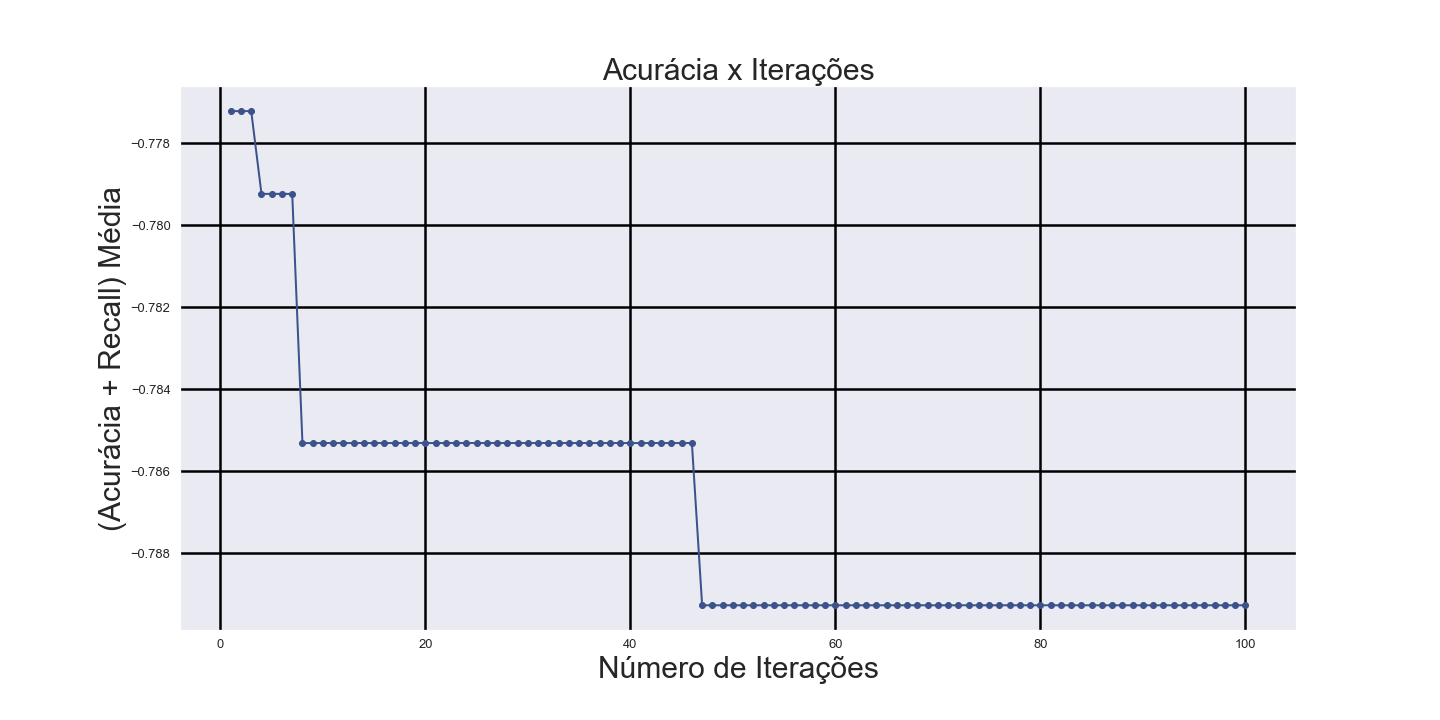

In [11]:
def minimizar_sgdc(params, r = results):
    loss = params[0]
    penalty = params[1]
    alpha = params[2]
    tol = params[3]

    #print(params)
    
    modelo = SGDClassifier(random_state = 7,
                           loss = loss,
                           penalty = penalty,
                           alpha = alpha,
                           tol = tol)
    
    R = r[r["Acurácia Média"] == r["Acurácia Média"].max()].values[0]
    
    escala = {"Original": None,
              "MinMaxScaler": preprocessing.MinMaxScaler(feature_range = (0, 1)),
              "StandardScaler": preprocessing.StandardScaler(),
              "RobustScaler": preprocessing.RobustScaler(),
              "MaxAbsScaler": preprocessing.MaxAbsScaler(),
              "Normalizer": preprocessing.Normalizer(),
              "QuantileTransformer": preprocessing.QuantileTransformer()}
    
    metricas = {"acc": "accuracy"}
    
    resultados = cross_validate(make_pipeline(escala[R[1]], modelo), X, Y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7), scoring = metricas)
    
    return - sum(resultados["test_acc"]) / 5

espaco = [("hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_loss", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"),
          ("l2", "l1", "elasticnet"),
          (1e-12, 1.0),
          (1e-12, 1.0)]

#resultados_otimizacao = gp_minimize(minimizar_sgdc, espaco, random_state = 7, n_calls = 100, n_random_starts = 10, verbose = False)

def iteracoes(resulta, arq, titulo = "(Acurácia + Recall)"):
    figure(figsize = (20,10))
    resulta.func_vals[0] = resulta.func_vals[1]
    plot_convergence(resulta)
    plt.title("%s x Iterações" %(titulo), fontsize = 30)
    plt.xlabel("Número de Iterações", fontsize = 30)
    plt.ylabel("(Acurácia + Recall) Média", fontsize = 30)
    plt.grid(color = 'black', linestyle = '-', linewidth = 2.5)
    plt.savefig(arq)
    plt.show()

#iteracoes(resultados_otimizacao, "imagem_diabetes_sgdc.png", "Acurácia")
    
display(Image(filename='imagem_diabetes_sgdc.png'))

________________________________________________________________MODELO OTIMIZADO APLICADO NOS DADOS DE VALIDAÇÃO:
________________________________________________________________ACURÁCIA:  0.7894736842105263
________________________________________________________________RECALL:  0.8709677419354839
________________________________________________________________PRECISÃO:  0.7714285714285715
________________________________________________________________F1:  0.8181818181818182
________________________________________________________________SELETIVIDADE:  0.6923076923076923
________________________________________________________________NPV:  0.8181818181818182


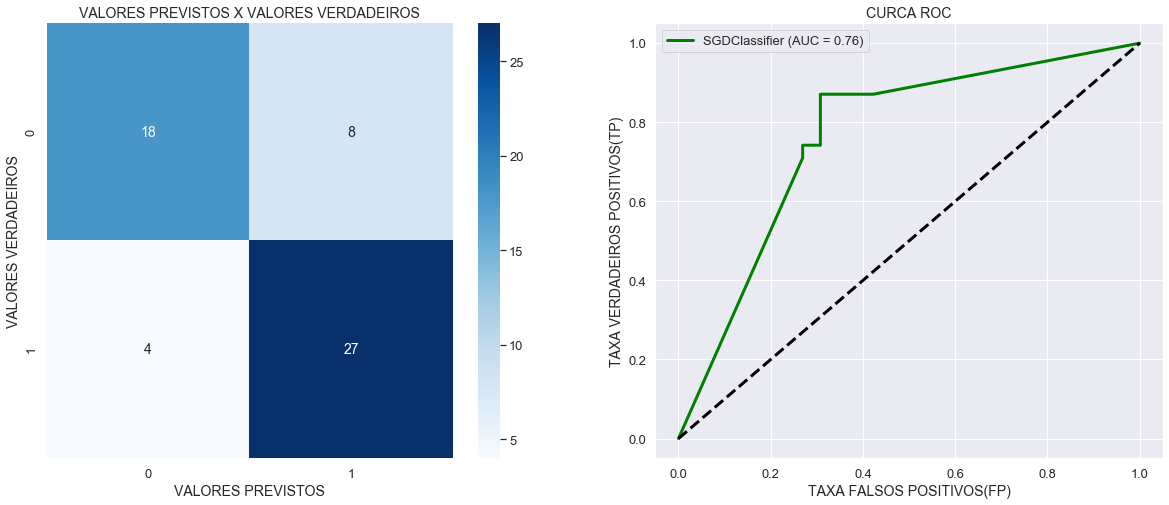

In [12]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from matplotlib.pyplot import figure
from sklearn import metrics

def modelos(modelo, Xtreino, Ytreino, Xteste, Yteste):
    sns.set(font_scale = 1.175)
    modelo.fit(Xtreino, Ytreino)
    
    valores_previstos = modelo.predict(Xteste)
        
    matriz = confusion_matrix(Yteste, valores_previstos)
    tn, fp, fn, tp = matriz.ravel()
    
    metricas = [accuracy_score(Yteste, valores_previstos),
                recall_score(Yteste, valores_previstos),
                precision_score(Yteste, valores_previstos),
                f1_score(Yteste, valores_previstos),
                tn / (tn + fp),
                tn / (tn + fn)]
    
    print("________________________________________________________________ACURÁCIA: ", metricas[0])
    print("________________________________________________________________RECALL: ", metricas[1])
    print("________________________________________________________________PRECISÃO: ", metricas[2])
    print("________________________________________________________________F1: ", metricas[3])
    print("________________________________________________________________SELETIVIDADE: ", metricas[4])
    print("________________________________________________________________NPV: ", metricas[5])
    
    fig, ax = plt.subplots(figsize = (20, 8), nrows = 1, ncols = 2)
    sns.heatmap(matriz, annot = True, cmap = "Blues", fmt = 'g', ax = ax[0])
    ax[0].set_title("VALORES PREVISTOS X VALORES VERDADEIROS")
    ax[0].set_xlabel("VALORES PREVISTOS")
    ax[0].set_ylabel("VALORES VERDADEIROS")
    
    metrics.plot_roc_curve(modelo, Xteste, Yteste, ax = ax[1], lw = 3, color = "green")
    a = sns.lineplot(x = [0,1], y = [0,1], color = "black", lw = 3, ax = ax[1])
    a.lines[1].set_linestyle("--")
    ax[1].set_title("CURCA ROC")
    ax[1].set_xlabel("TAXA FALSOS POSITIVOS(FP)")
    ax[1].set_ylabel("TAXA VERDADEIROS POSITIVOS(TP)")
    
    plt.show()

arquivo = "modelo_cancer_sgdc.sav"
'''
pickle.dump(SGDClassifier(random_state = 7,
                          loss = resultados_otimizacao.x[0],
                          penalty = resultados_otimizacao.x[1],
                          alpha = resultados_otimizacao.x[2],
                          tol = resultados_otimizacao.x[3]), open(arquivo, 'wb'))
'''
modelo_otimizado = pickle.load(open(arquivo, 'rb'))

print("________________________________________________________________MODELO OTIMIZADO APLICADO NOS DADOS DE VALIDAÇÃO:")
modelos(modelo_otimizado, X, Y, X_val0, Y_val)

________________________________________________________________ACURÁCIA:  0.7409638554216867
________________________________________________________________RECALL:  0.8072289156626506
________________________________________________________________PRECISÃO:  0.7127659574468085
________________________________________________________________F1:  0.7570621468926554
________________________________________________________________SELETIVIDADE:  0.6746987951807228
________________________________________________________________NPV:  0.7777777777777778


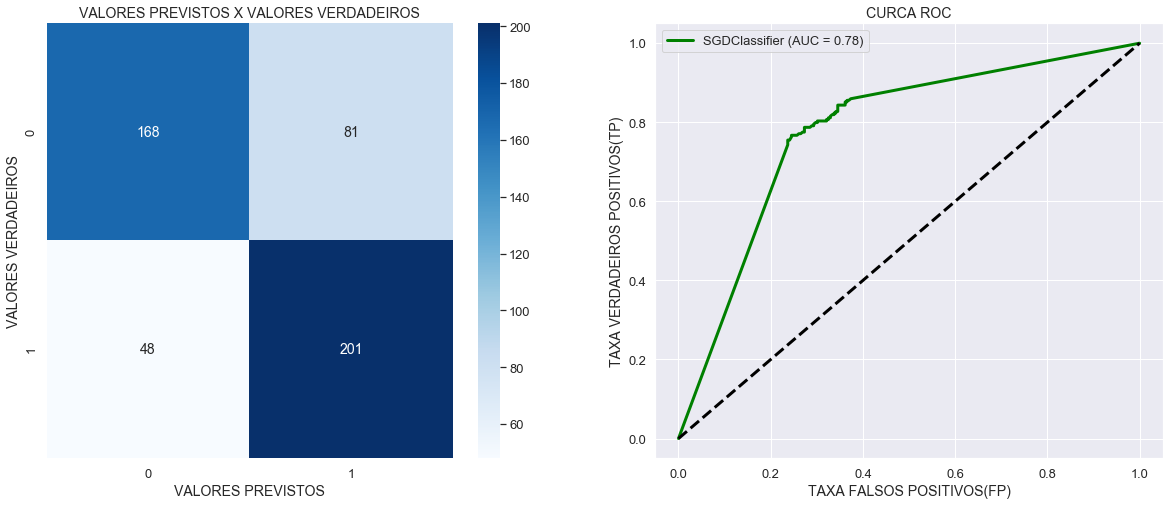

In [13]:
modelos(modelo_otimizado, X, Y, X, Y)

________________________________________________________________ACURÁCIA:  0.74822695035461
________________________________________________________________RECALL:  0.8142857142857143
________________________________________________________________PRECISÃO:  0.7169811320754716
________________________________________________________________F1:  0.7625418060200667
________________________________________________________________SELETIVIDADE:  0.6830985915492958
________________________________________________________________NPV:  0.7886178861788617


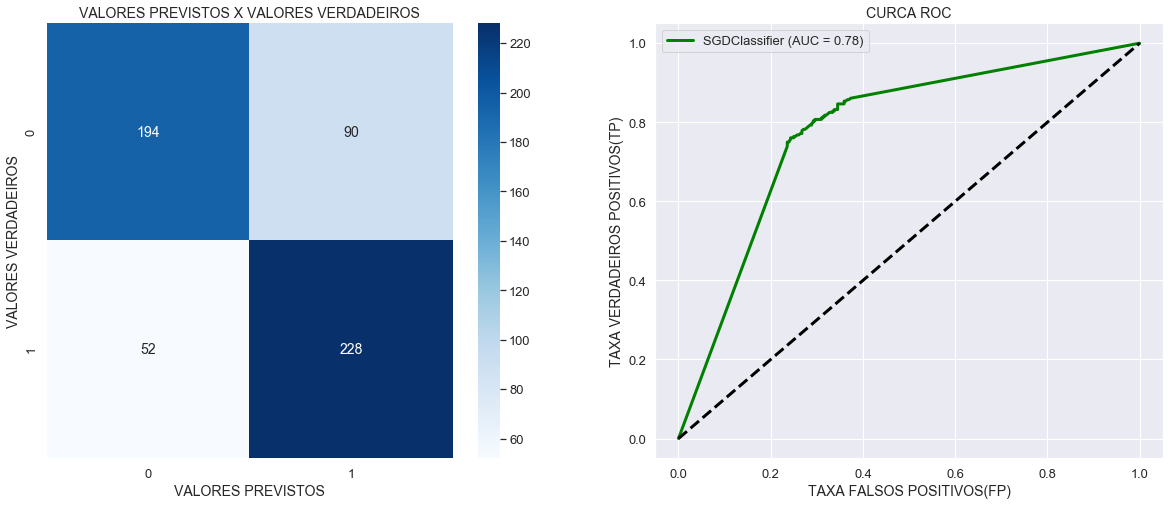

In [14]:
x0, y = previsao(r = results, g1 = novos_dados.loc[:,novos_dados.columns != "Severity"], g2 = novos_dados.Severity)
x0 = x0.values
y = y.values

modelos(modelo_otimizado, X, Y, x0, y)